Script for generating Fig 9:
- (a, b) Depth-mean temperature anomalies of the MW45 and MW85 simulations compared with the
control, averaged over the final year of the experimental period. Inset values summarize the continental shelf heat
budget, averaged over the experimental period, shown as an anomaly relative to the control simulation. Note that
the time-mean advective and surface heat fluxes into the region are +42:2 TW and ?42:1 TW respectively for
the control simulation. Heat fluxes are computed relative to 0C. Black contours mark the 1000 m isobath, whilst
green contours show a continuous approximation of the 3000 m isobath. Thick black lines partition the Ross
Sea and West Antarctica continental shelf regions considered in (d-g). (c) Timeseries of monthly mean volumeaveraged
temperature anomalies on the continental shelf (solid lines - region poleward of the 1000 m isobath)
and continental slope (dashed lines - region between the 1000 m and 3000 m isobaths). Anomalies are computed
relative to the control simulation. (d-g) Potential temperature anomalies, relative to the control run, averaged
over the Ross Sea (c, d) and West Antarctica (e, f) continental shelf regions delineated in (a). Volume-averaged
temperature anomalies for the final year of the experimental period are inset. When considering seasonal signals,
note that the experimental period starts in May.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('text', usetex=True)
rc('xtick', labelsize=35) 
rc('ytick', labelsize=35) 
rc('axes', labelsize=35) 
import cmocean.cm as cmo

In [13]:
import matplotlib.cm as cm
cmap = cm.get_cmap('Oranges')
orange_color = cmap(0.75)
import matplotlib.ticker as mticker

In [2]:
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [3]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [4]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

Depth mean temperature anomalies where computed using the following depth averaging function:
```
def depthmean_temp_map(var, dzt):
    var_scaled = var * dzt;
    var_scaled_sum = var_scaled.sum(dim = 'st_ocean');
    sum_depth = dzt.sum(dim = 'st_ocean')
    var_weighted_mean = var_scaled_sum /sum_depth;
    return var_weighted_mean
    ```

### Maps

In [17]:
filename = '../Honours_Thesis/Maps/rcp45_depthmean_temp_end.nc'
depthmean_temp_rcp45_end = xr.open_dataset(filename)
depthmean_temp_rcp45_end = depthmean_temp_rcp45_end.temp
filename = '../Honours_Thesis/Maps/rcp85_depthmean_temp_end.nc'
depthmean_temp_rcp85_end = xr.open_dataset(filename)
depthmean_temp_rcp85_end = depthmean_temp_rcp85_end.temp
filename = '../Honours_Thesis/Maps/control_depthmean_temp_end.nc'
depthmean_temp_control_end = xr.open_dataset(filename)
depthmean_temp_control_end = depthmean_temp_control_end.temp

In [18]:
temp_rcp85_anomaly = depthmean_temp_rcp85_end - depthmean_temp_control_end
temp_rcp45_anomaly = depthmean_temp_rcp45_end - depthmean_temp_control_end

In [8]:
# to accompany the 1000m shelf categorisation, I created a continous approximation of the 3000 m isobath such that the 1000-3000 region may be defined as the slope
slope_mask = xr.open_dataset('/g/data/v45/rm2389/slope_mask_1000_3000_isobaths.nc')
slope_mask = slope_mask.slope_mask
slope_map = slope_mask.fillna(0)
shelf_map = shelf_mask.where(shelf_mask>0)

In [25]:
def mean_pot_temp_anomaly_maps(ax0, ax1, mcmap):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ## temp maps
    norm1 = col.Normalize(vmin=-2,vmax=2) 
    fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    anomaly_temp = ax0.pcolormesh(temp_rcp45_anomaly.xt_ocean,temp_rcp45_anomaly.yt_ocean,temp_rcp45_anomaly.values,cmap=mcmap,norm=norm1,transform=ccrs.PlateCarree())
    ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax0.contour(slope_map.xt_ocean, slope_map.yt_ocean,slope_map,[0,1], colors = 'g', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
    ax0.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
    ax1.pcolormesh(temp_rcp85_anomaly.xt_ocean,temp_rcp85_anomaly.yt_ocean,temp_rcp85_anomaly.values,cmap=mcmap,norm=norm1,transform=ccrs.PlateCarree())
    ax1.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax1.contour(slope_map.xt_ocean, slope_map.yt_ocean,slope_map,[0,1], colors = 'g', linewidth = 4, transform=ccrs.PlateCarree())
    ax1.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
    gl = ax1.gridlines(linewidth = 1, color = 'silver', linestyle = '--')
    gl.ylocator = mticker.FixedLocator([-90,-80,-70])
    gl = ax0.gridlines(linewidth = 1, color = 'silver', linestyle = '--')
    gl.ylocator = mticker.FixedLocator([-90,-80,-70])
    return anomaly_temp

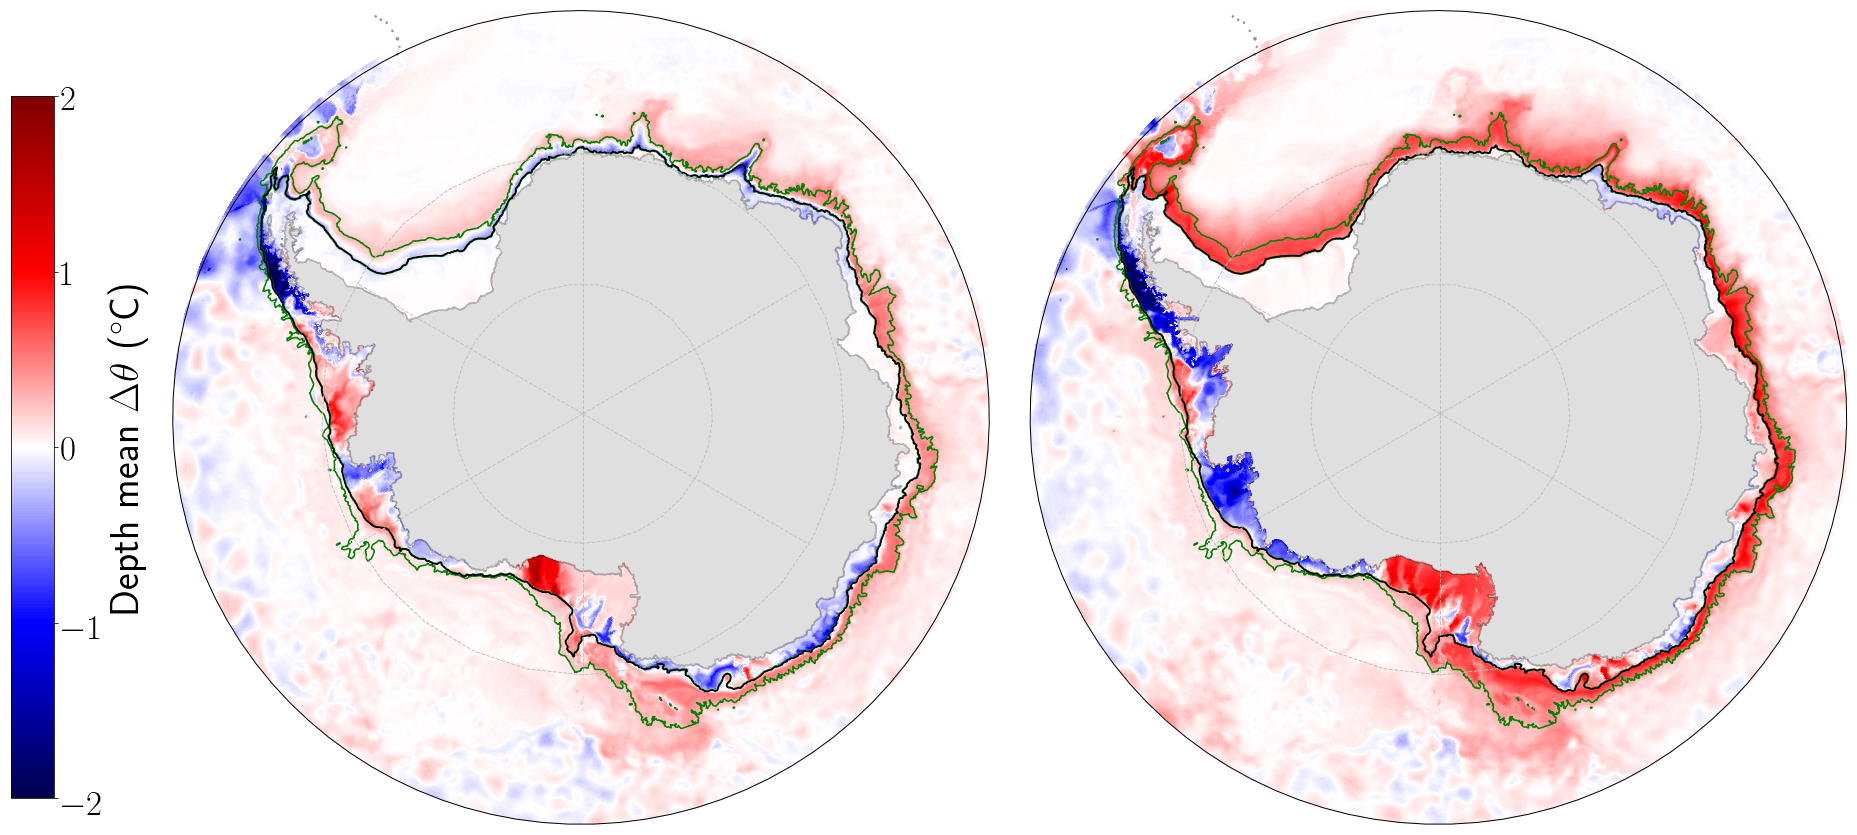

In [26]:
fig = plt.figure(figsize = (30,15))
gs = gridspec.GridSpec(1,2)
gs.update(wspace = 0.05)
ax0, ax1= plt.subplot(gs[0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1],projection=ccrs.SouthPolarStereo())
anomaly_temp = mean_pot_temp_anomaly_maps(ax0,ax1,'seismic')
cax = fig.add_axes([0.05, 0.15, 0.02, 0.65])
cbar=plt.colorbar(anomaly_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-3, -2,-1,0,1,2, 3])
cbar.set_label(r'Depth mean $\Delta\theta$ ($^\circ$C)', fontsize = 40)
figurepath = 'Fig9ab.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='png',
                transparent=False, bbox_inches='tight', pad_inches=0.1,
                frameon=None)
plt.show()

### Timeseries

I wont redo the protocol as the computation is time consuming, but the procedure is as follows:

Define the following function,
```
def volume_averaged(var, dzt, dxt, dyt):
    var_scaled_sum = (var * dzt * dxt * dyt).sum(dim = {'st_ocean', 'xt_ocean','yt_ocean'})
    volume_sum = (dxt * dyt * dzt).sum(dim = {'st_ocean', 'xt_ocean','yt_ocean'})
    var_volume_mean = var_scaled_sum /volume_sum;
    return var_volume_mean
```
    
Masked all variables,

```
temp_rcp85_shelf, shelf_mask = shelf_mask_isobath(temp_rcp85)
dzt_rcp85_shelf, shelf_mask = shelf_mask_isobath(dzt_rcp85)
temp_rcp45_shelf, shelf_mask = shelf_mask_isobath(temp_rcp45)
dzt_rcp45_shelf, shelf_mask = shelf_mask_isobath(dzt_rcp45)
temp_control_shelf, shelf_mask = shelf_mask_isobath(temp_control)
dzt_control_shelf, shelf_mask = shelf_mask_isobath(dzt_control)
dxt_shelf, shelf_mask = shelf_mask_isobath(dxt)
dyt_shelf, shelf_mask = shelf_mask_isobath(dyt)
```
Had memory issues doing the full timeseries at ocne so did the following loop,
```
mean_slope_temp_rcp85 = xr.DataArray(np.zeros((len(time))),coords = [time],dims = ['time'])
for i in range(5):
    temp_slope_i = temp_rcp85_slope.isel(time = slice(i*24,i*24+24))
    dzt_slope_i = dzt_rcp85_slope.isel(time = slice(i*24,i*24+24))
    mean_slope_temp_i = volume_averaged(temp_slope_i, dzt_slope_i, dxt_slope, dyt_slope)
    mean_slope_temp_i = mean_slope_temp_i.load()
    mean_slope_temp_rcp85[i*24:i*24+24] = mean_slope_temp_i
    print(i)
    del temp_slope_i, dzt_slope_i, mean_slope_temp_i
ds = xr.Dataset({'slope_mean_temp_rcp85':mean_slope_temp_rcp85})
ds.to_netcdf('/g/data/v45/rm2389/Water_Mass_Tracers/rcp85_slope_temp.nc')
```

and the same for shelf values

In [27]:
shelf_mean_temp_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/control_shelf_temp.nc')
shelf_mean_temp_rcp45 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp45_shelf_temp.nc')
shelf_mean_temp_rcp85 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp85_shelf_temp.nc')
shelf_mean_temp_control = shelf_mean_temp_control.shelf_mean_temp_control
shelf_mean_temp_rcp45 = shelf_mean_temp_rcp45.shelf_mean_temp_rcp45
shelf_mean_temp_rcp85 = shelf_mean_temp_rcp85.shelf_mean_temp_rcp85
slope_mean_temp_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/control_slope_temp.nc')
slope_mean_temp_rcp45 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp45_slope_temp.nc')
slope_mean_temp_rcp85 = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/rcp85_slope_temp.nc')
slope_mean_temp_control = slope_mean_temp_control.slope_mean_temp_control
slope_mean_temp_rcp45 = slope_mean_temp_rcp45.slope_mean_temp_rcp45
slope_mean_temp_rcp85 = slope_mean_temp_rcp85.slope_mean_temp_rcp85
rcp45_shelf_anomaly = shelf_mean_temp_rcp45 - shelf_mean_temp_control
rcp45_slope_anomaly = slope_mean_temp_rcp45 - slope_mean_temp_control
rcp85_slope_anomaly = slope_mean_temp_rcp85 - slope_mean_temp_control
rcp85_shelf_anomaly = shelf_mean_temp_rcp85 - shelf_mean_temp_control

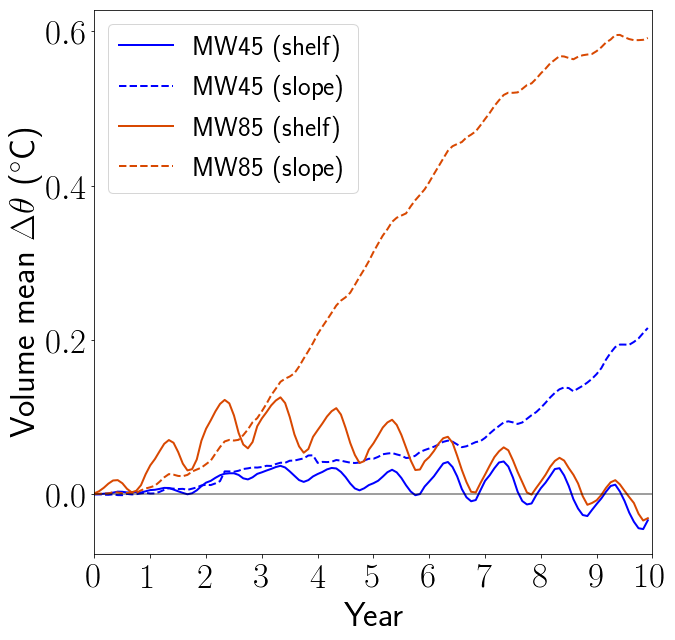

In [28]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot()
year = np.arange(0,10, 1/12)
ax.plot(year, rcp45_shelf_anomaly, 'b', linewidth = 2, label = 'MW45 (shelf)')
ax.plot(year, rcp45_slope_anomaly, 'b', linestyle = '--', linewidth = 2, label = 'MW45 (slope)')
ax.plot(year, rcp85_shelf_anomaly, color = orange_color, linewidth = 2, label = 'MW85 (shelf)')
ax.plot(year, rcp85_slope_anomaly, color = orange_color, linestyle = '--', linewidth = 2, label = 'MW85 (slope)')
ax.plot([0,10], [0,0], 'k', alpha = 0.5)
ax.set_xlim((0,10))
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xlabel('Year')
ax.set_ylabel(r'Volume mean $\Delta \theta$ ($^\circ$C)')
ax.legend(loc = 2, fontsize = 27)

figurepath = 'Fig10c.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='png',
                transparent=False, bbox_inches='tight', pad_inches=0.1,
                frameon=None)
plt.show()

### Hovmollers

In [29]:
def hovmoller_mean_2D(var, dxt, dyt, lon1, lon2):
    # Step 1: Slice the variable DataArray and the grid information DataArrays
    var_region = var.sel(xt_ocean = slice(lon1,lon2))
    var_dxt = dxt.sel(xt_ocean = slice(lon1,lon2))
    var_dyt = dyt.sel(xt_ocean = slice(lon1,lon2))
    # Step 2: Computed weighted average
    var_scaled = var_region * var_dxt * var_dyt;
    var_scaled_sum = var_scaled.sum(dim = 'xt_ocean').sum(dim = 'yt_ocean');
    ## need to divide by the area 
    cell_areas = var_dxt * var_dyt
    area_sum = cell_areas.sum(dim = 'yt_ocean').sum(dim = 'xt_ocean')
    var_weighted_average = var_scaled_sum/area_sum
    return var_weighted_average

In [30]:
blank = shelf_mask * 0 + 1
west_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -60).where(blank.xt_ocean > -157).where(blank.xt_ocean < -63)
west_map = west_mask.fillna(0)
ross_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -60).where(blank.xt_ocean > -198).where(blank.xt_ocean < -157)
ross_map = ross_mask.fillna(0)

In [63]:
temp_rcp45 = cc.querying.getvar(rcp45, 'temp', session, ncfile = 'ocean.nc')
temp_rcp85 = cc.querying.getvar(rcp85, 'temp', session, ncfile = 'ocean.nc')
temp_control =  cc.querying.getvar(control, 'temp', session, ncfile = 'ocean.nc')
timeslice = slice('1937-06', '1947-05')
temp_rcp45 = temp_rcp45.sel(time = timeslice)
temp_rcp85 = temp_rcp85.sel(time = timeslice)
temp_control = temp_control.sel(time = timeslice)

In [68]:
temp_rcp45_anomaly = temp_rcp45 - temp_control
temp_rcp45_anomaly, shelf_mask = shelf_mask_isobath(temp_rcp45_anomaly)
temp_rcp85_anomaly = temp_rcp85 - temp_control
temp_rcp85_anomaly, shelf_mask = shelf_mask_isobath(temp_rcp85_anomaly)

Then I did this for each section
```
west_antarctica_temp_rcp45_anomaly = hovmoller_mean_2D(temp_rcp45_anomaly, dxt, dyt, -157, -63)
west_antarctica_temp_rcp45_anomaly = west_antarctica_temp_rcp45_anomaly.load()
ds = xr.Dataset({'temp_hovmoller': west_antarctica_temp_rcp45_anomaly})
ds.to_netcdf('../Honours_Thesis/Hoevmoller_Plots_Variability/RCP4.5/new_west_antarctica_temp_anomaly_RCP45.nc')
```
and here I reload that output

In [34]:
west_antarctica_temp_rcp45_anomaly = xr.open_dataset('../Honours_Thesis/Hoevmoller_Plots_Variability/RCP4.5/new_west_antarctica_temp_anomaly_RCP45.nc')
west_antarctica_temp_rcp45_anomaly = west_antarctica_temp_rcp45_anomaly.temp_hovmoller
west_antarctica_temp_rcp85_anomaly = xr.open_dataset('../Honours_Thesis/Hoevmoller_Plots_Variability/RCP8.5/new_west_antarctica_temp_anomaly_RCP85.nc')
west_antarctica_temp_rcp85_anomaly = west_antarctica_temp_rcp85_anomaly.temp_hovmoller

ross_temp_rcp45_anomaly = xr.open_dataset('../Honours_Thesis/Hoevmoller_Plots_Variability/RCP4.5/new_ross_temp_anomaly_RCP45.nc')
ross_temp_rcp45_anomaly = ross_temp_rcp45_anomaly.temp_hovmoller
ross_temp_rcp85_anomaly = xr.open_dataset('../Honours_Thesis/Hoevmoller_Plots_Variability/RCP8.5/new_ross_temp_anomaly_RCP85.nc')
ross_temp_rcp85_anomaly = ross_temp_rcp85_anomaly.temp_hovmoller

In [45]:
def west_temp_hovmoller(ax0, ax1, hcmap):
    norm1 = col.Normalize(vmin=-1.5,vmax=1.5)  
    a = np.linspace(0,10,120)   
    st_ocean = west_antarctica_temp_rcp45_anomaly.st_ocean
    ## rcp45
    plot = ax0.pcolormesh(a,st_ocean,np.transpose(west_antarctica_temp_rcp45_anomaly.values),cmap=hcmap, norm=norm1)
    ax0.set_yticks([0,100, 200, 300, 400, 500, 600, 700,800,900,1000])
    ax0.invert_yaxis()
    ax0.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax0.set_xlabel('Year',fontsize = 40)
    ax0.set_ylim([1000,0])
    ax1.pcolormesh(a,st_ocean,np.transpose( west_antarctica_temp_rcp85_anomaly.values),cmap=hcmap, norm=norm1)
    ax1.set_yticks([0,100, 200, 300, 400, 500, 600, 700,800,900,1000])
    ax1.invert_yaxis()
    ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax1.set_xlabel('Year',fontsize = 40)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax0.get_yticklabels(), visible=False)
    ax1.set_ylim([1000,0])
    return plot

In [36]:
def ross_temp_hovmoller(ax0, ax1, hcmap):
    norm1 = col.Normalize(vmin=-1.5,vmax=1.5)  
    a = np.linspace(0,10,120)   
    st_ocean = west_antarctica_temp_rcp45_anomaly.st_ocean
    ## rcp45
    plot = ax0.pcolormesh(a,st_ocean,np.transpose(ross_temp_rcp45_anomaly.values),cmap=hcmap, norm=norm1)
    ax0.set_yticks([0,100, 200, 300, 400, 500, 600, 700,800,900,1000])
    ax0.invert_yaxis()
    ax0.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax0.set_ylabel('Depth (m)', fontsize = 40)
    ax0.set_xlabel('Year',fontsize = 40)
    ax0.set_ylim([1000,0])
    ax1.pcolormesh(a,st_ocean, np.transpose(ross_temp_rcp85_anomaly.values),cmap=hcmap, norm=norm1)
    ax1.set_yticks([0,100, 200, 300, 400, 500, 600, 700,800,900,1000])
    ax1.invert_yaxis()
    ax1.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax1.set_xlabel('Year',fontsize = 40)
    plt.setp(ax1.get_yticklabels(), visible=False)
    ax1.set_ylim([1000,0])
    return plot

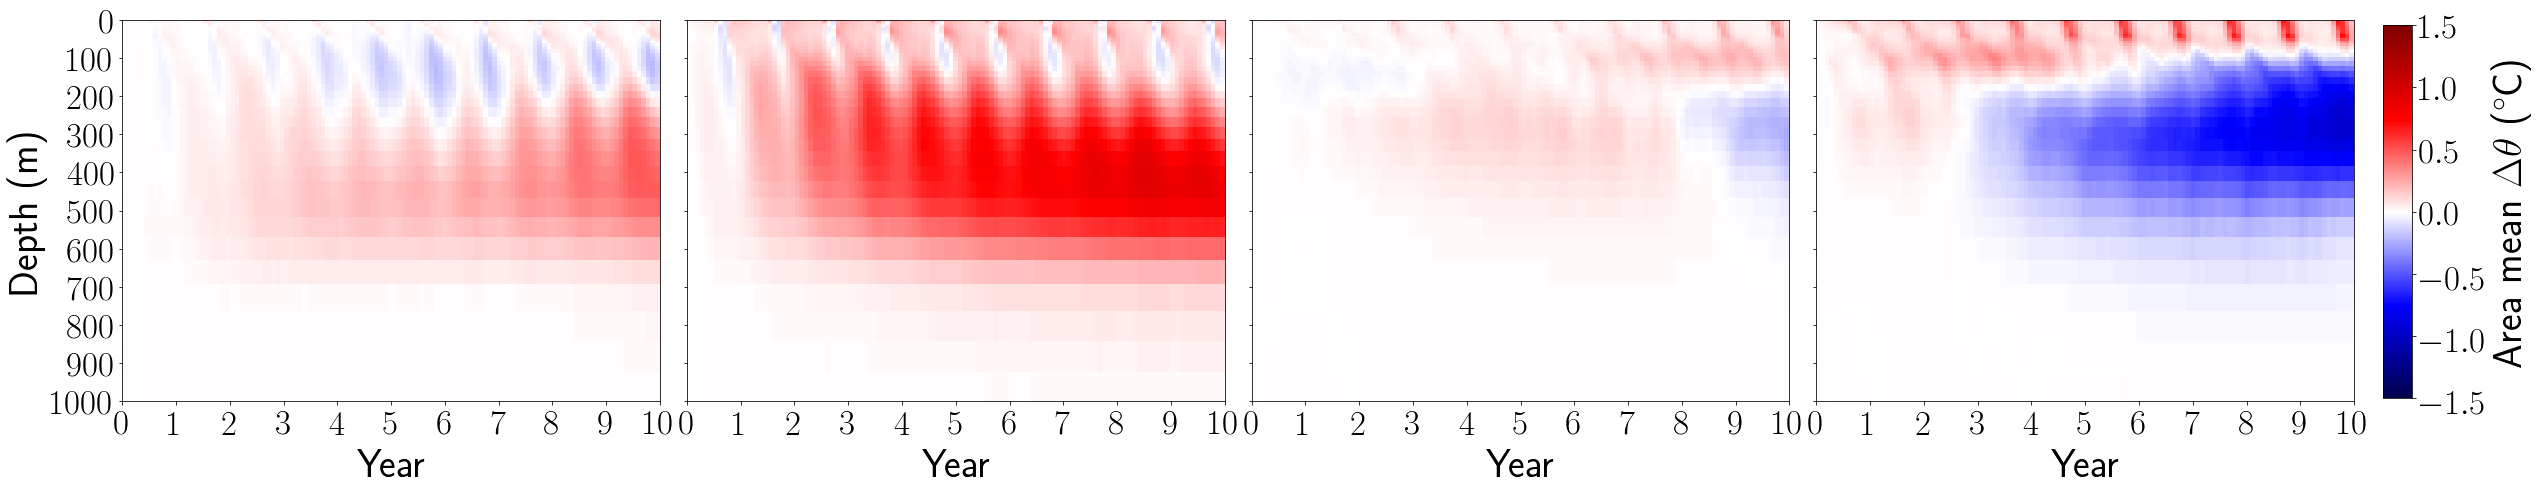

In [50]:
fig = plt.figure(figsize = (40,7))


gs = gridspec.GridSpec(1,4)
gs.update(hspace = 0.1, wspace = 0.05)

ax0, ax1, ax2, ax3= plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]), plt.subplot(gs[3])
hovmoller = ross_temp_hovmoller(ax0, ax1, 'seismic')
west_temp_hovmoller(ax2, ax3, 'seismic')

cax = fig.add_axes([0.91, 0.13, 0.01, 0.74])
cbar=plt.colorbar(hovmoller,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-1.5,-1,-0.5,0,0.5,1,1.5])
cbar.set_label(r'Area mean $\Delta\theta$ ($^\circ$C)', fontsize = 40)

figurepath = 'Fig10dg.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='png',
                transparent=False, bbox_inches='tight', pad_inches=0.1,
                frameon=None)


plt.show()

### Final year volume mean temp anomalies
Values are inset in fig 10 d-g in the manuscript

In [51]:
def volume_averaged(var, dzt, dxt, dyt):
    var_scaled = var * dzt * dxt * dyt
    var_scaled_sum = var_scaled.sum(dim = 'st_ocean').sum(dim = 'xt_ocean').sum(dim = 'yt_ocean')
    volume = dxt * dyt * dzt
    volume_sum = volume.sum(dim = 'st_ocean').sum(dim = 'xt_ocean').sum(dim = 'yt_ocean')
    var_volume_mean = var_scaled_sum /volume_sum;
    return var_volume_mean

In [70]:
temp_rcp45_end = temp_rcp45.sel(time = slice('1946-06', '1947-05')).sel(yt_ocean = slice(-90,-59))
temp_rcp85_end = temp_rcp85.sel(time = slice('1946-06', '1947-05')).sel(yt_ocean = slice(-90,-59))
temp_control_end = temp_control.sel(time = slice('1946-06', '1947-05')).sel(yt_ocean = slice(-90,-59))

In [56]:
dxt = cc.querying.getvar(rcp45, 'dxt', session, ncfile = 'ocean_grid.nc', n=1)
dyt = cc.querying.getvar(rcp45, 'dyt', session, ncfile = 'ocean_grid.nc', n=1)
dzt_control = cc.querying.getvar(control, 'dzt', session, ncfile = 'ocean.nc')
dzt_rcp45= cc.querying.getvar(rcp45, 'dzt', session, ncfile = 'ocean.nc')
dzt_rcp85= cc.querying.getvar(rcp85, 'dzt', session, ncfile = 'ocean.nc')
dzt_control_end = dzt_control.sel(time = slice('1946-06', '1947-05'))
dzt_rcp45_end = dzt_rcp45.sel(time = slice('1946-06', '1947-05'))
dzt_rcp85_end = dzt_rcp85.sel(time = slice('1946-06', '1947-05'))

In [76]:
temp_control_west = temp_control_end * west_mask
temp_rcp45_west = temp_rcp45_end * west_mask
temp_rcp85_west = temp_rcp85_end * west_mask
dxt_west = dxt * west_mask
dyt_west = dyt * west_mask
dzt_control_west = dzt_control_end * west_mask
dzt_rcp45_west = dzt_rcp45_end * west_mask
dzt_rcp85_west = dzt_rcp85_end * west_mask
west_control_mean = volume_averaged(temp_control_west, dzt_control_west, dxt_west, dyt_west)
west_control_mean = west_control_mean.load()
west_rcp45_mean = volume_averaged(temp_rcp45_west, dzt_rcp45_west, dxt_west, dyt_west)
west_rcp45_mean = west_rcp45_mean.load()
west_rcp85_mean = volume_averaged(temp_rcp85_west, dzt_rcp85_west, dxt_west, dyt_west)
west_rcp85_mean = west_rcp85_mean.load()

In [77]:
time = west_rcp85_mean.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
west_control_mean = (west_control_mean * weights).mean(dim = 'time') - 273.15
west_rcp45_mean = (west_rcp45_mean * weights).mean(dim = 'time') - 273.15
west_rcp85_mean = (west_rcp85_mean * weights).mean(dim = 'time') - 273.15
print('West Control',west_control_mean.values)
print('West RCP4.5',west_rcp45_mean.values)
print('West RCP8.5',west_rcp85_mean.values)
print('West RCP4.5 anomaly',(west_rcp45_mean.values-west_control_mean.values))
print('West RCP8.5 anomaly',(west_rcp85_mean.values-west_control_mean.values))

West Control 0.9547639193600617
West RCP4.5 0.9707361508722556
West RCP8.5 0.9827546420163458
West RCP4.5 anomaly 0.015972231512193957
West RCP8.5 anomaly 0.027990722656284106


In [78]:
temp_control_ross = temp_control_end * ross_mask
temp_rcp45_ross = temp_rcp45_end * ross_mask
temp_rcp85_ross = temp_rcp85_end * ross_mask
dxt_ross = dxt * ross_mask
dyt_ross = dyt * ross_mask
dzt_control_ross = dzt_control_end * ross_mask
dzt_rcp45_ross = dzt_rcp45_end * ross_mask
dzt_rcp85_ross = dzt_rcp85_end * ross_mask
ross_control_mean = volume_averaged(temp_control_ross, dzt_control_ross, dxt_ross, dyt_ross)
ross_control_mean = ross_control_mean.load()
ross_rcp45_mean = volume_averaged(temp_rcp45_ross, dzt_rcp45_ross, dxt_ross, dyt_ross)
ross_rcp45_mean = ross_rcp45_mean.load()
ross_rcp85_mean = volume_averaged(temp_rcp85_ross, dzt_rcp85_ross, dxt_ross, dyt_ross)
ross_rcp85_mean = ross_rcp85_mean.load()

In [79]:
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
ross_control_mean = (ross_control_mean * weights).mean(dim = 'time') - 273.15
ross_rcp45_mean = (ross_rcp45_mean * weights).mean(dim = 'time') - 273.15
ross_rcp85_mean = (ross_rcp85_mean * weights).mean(dim = 'time') - 273.15
print('Ross Control',ross_control_mean.values)
print('Ross RCP4.5',ross_rcp45_mean.values)
print('Ross RCP8.5',ross_rcp85_mean.values)
print('Ross RCP4.5 anomaly',(ross_rcp45_mean.values-ross_control_mean.values))
print('Ross RCP8.5 anomaly',(ross_rcp85_mean.values-ross_control_mean.values))

Ross Control 0.734630678777819
Ross RCP4.5 0.8105067422945353
Ross RCP8.5 0.8646159132866273
Ross RCP4.5 anomaly 0.07587606351671639
Ross RCP8.5 anomaly 0.1299852345088084
